<a href="https://colab.research.google.com/github/zizozozaziad1/Cats-Vs-Dogs/blob/main/Cats_vs_dogs_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are embarking on a project aimed at developing image classifiers capable of distinguishing between images of cats and dogs.





First, we will begin by importing the 'dogs-vs-cats' dataset from Kaggle and proceed to unzip it.

In [19]:
! pip install kaggle


In [20]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [21]:
! cp kaggle.json ~/.kaggle/


In [22]:
!kaggle competitions download -c dogs-vs-cats


dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
! unzip dogs-vs-cats.zip


Archive:  dogs-vs-cats.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip train.zip
!unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

Now, we will import the necessary libraries and modules required for our project

In [24]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

Let's create our custom dataset (A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. )

In [25]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = 1 if self.file_list[idx].startswith("dog") else 0

        return image, label

Let's define our data directories

In [26]:

train_dir = '/content/train'
test_dir = '/content/test1'

Let's # Define data transforms ( Image augmentation)


In [27]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [28]:
train_dataset = CustomDataset(train_dir, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

Setting Up the Model and Training Configuration:

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[500, 1000, 1500], gamma=0.5)

epochs = 8
loss_list = []
acc_list = []


In [30]:

model.train()
for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += len(labels)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = total_correct.double() / total_samples

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc.item())
    scheduler.step()









Epoch 1/8, Loss: 0.3431, Accuracy: 0.8483
Epoch 2/8, Loss: 0.2203, Accuracy: 0.9084
Epoch 3/8, Loss: 0.1845, Accuracy: 0.9230
Epoch 4/8, Loss: 0.1614, Accuracy: 0.9322
Epoch 5/8, Loss: 0.1400, Accuracy: 0.9432
Epoch 6/8, Loss: 0.1328, Accuracy: 0.9445
Epoch 7/8, Loss: 0.1187, Accuracy: 0.9541
Epoch 8/8, Loss: 0.1090, Accuracy: 0.9548


Let's save the model

In [31]:
filename_pth = 'ckpt_densenet121_catdog.pth'
torch.save(model.state_dict(), filename_pth)

Transform the test images to the same size as the trained ones and then to a tensor

In [32]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

Create dataloader for test images to iterate easily through them

In [33]:

test_dataset = CustomDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [34]:

model.eval()
ad = {0: 'cat', 1: 'dog'}

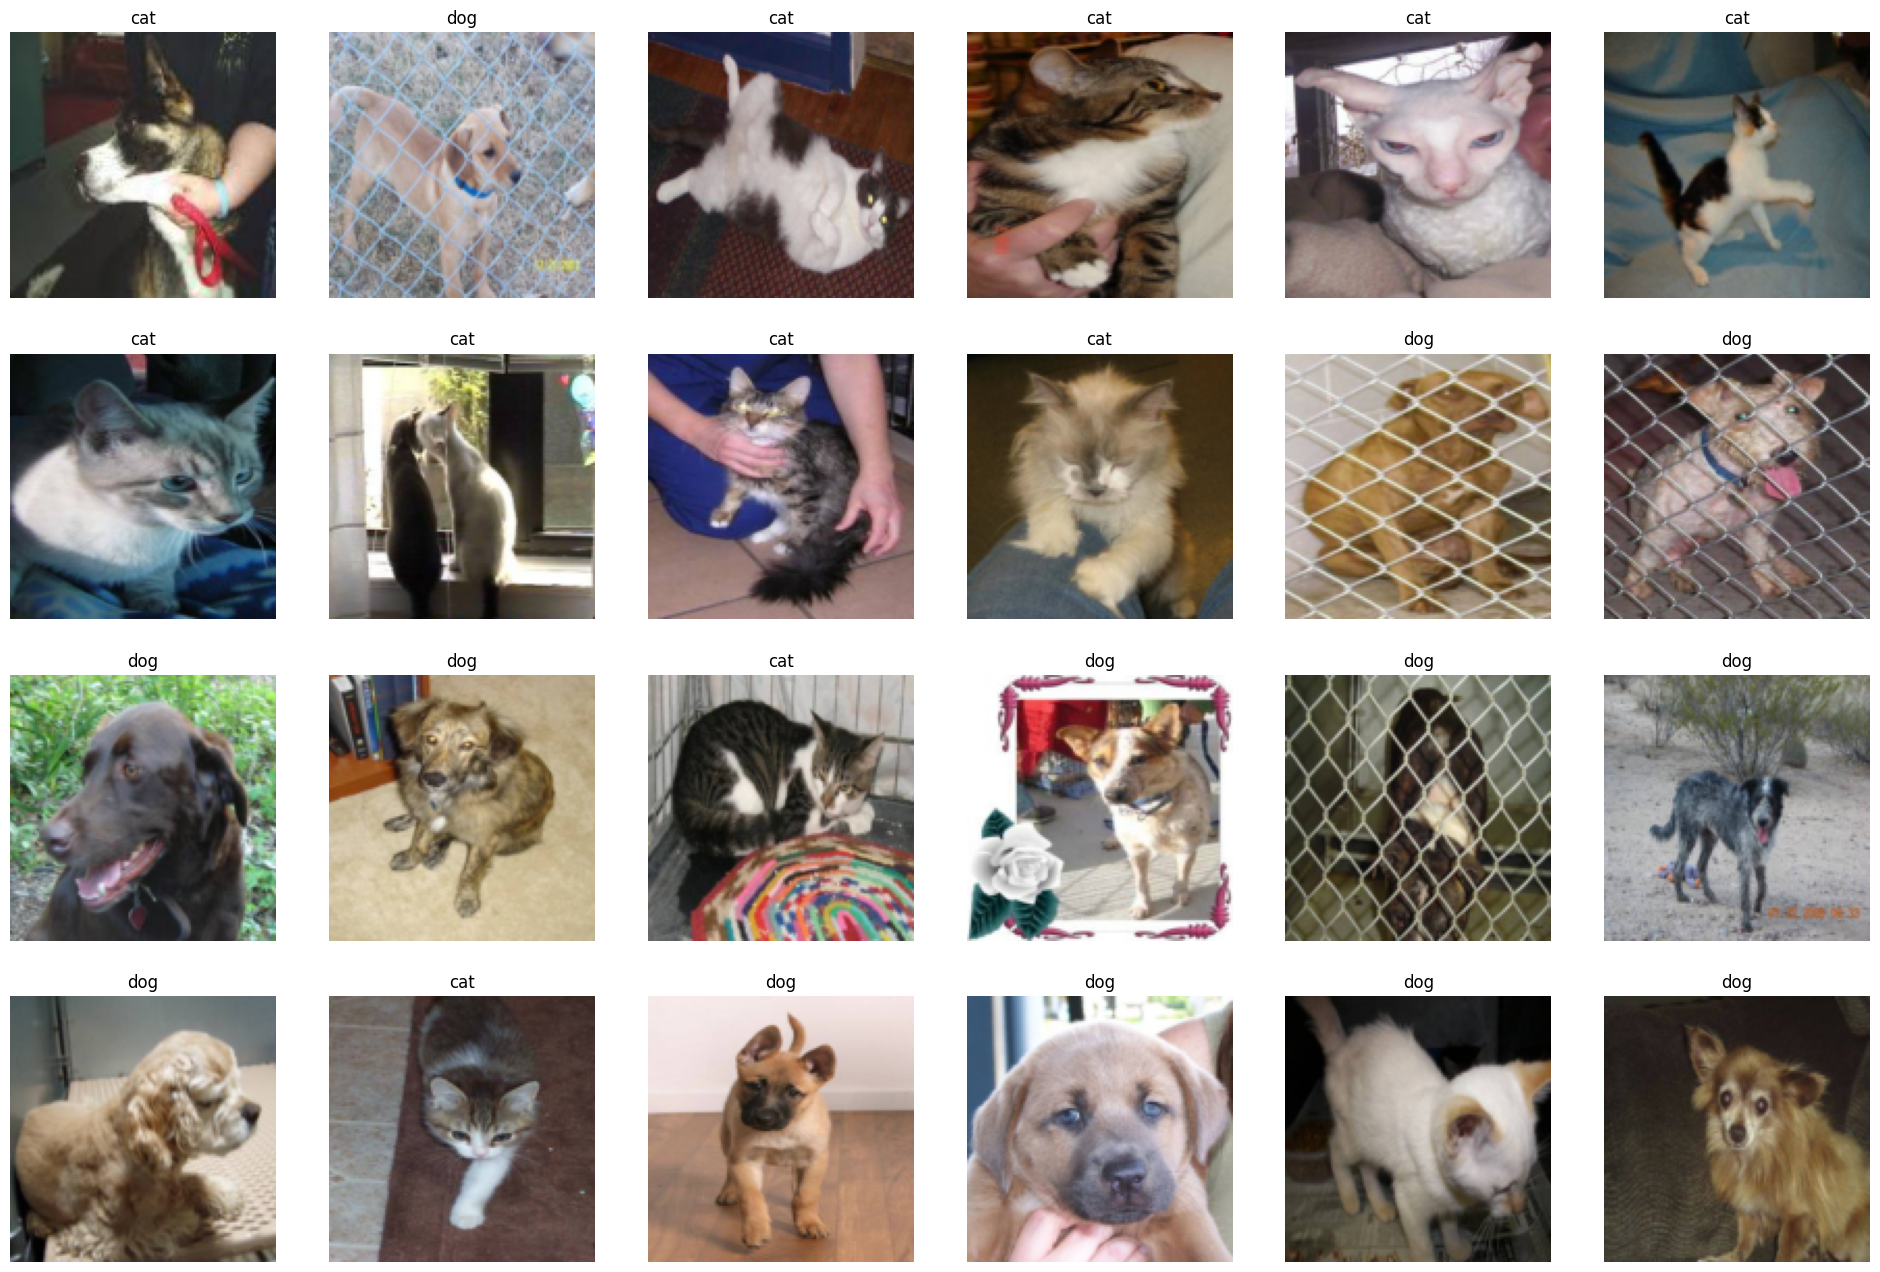

In [35]:
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
grid_rows, grid_cols = 4, 6

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        if i >= (grid_rows * grid_cols):
            break
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(grid_rows, grid_cols, i + 1)
        ax.set_title(ad[preds[0].item()])
        ax.axis('off')
        img = images.cpu().data[0].numpy().transpose((1, 2, 0))
        plt.imshow(img)

plt.show()


Now let's test the model from images I've got myself from google

In [36]:
!unzip myimages.zip

Archive:  myimages.zip
  inflating: myimages/1.jpg          
  inflating: myimages/2.jpg          
  inflating: myimages/3.jpg          
  inflating: myimages/4.jpg          
  inflating: myimages/5.jpg          
  inflating: myimages/6.jpg          


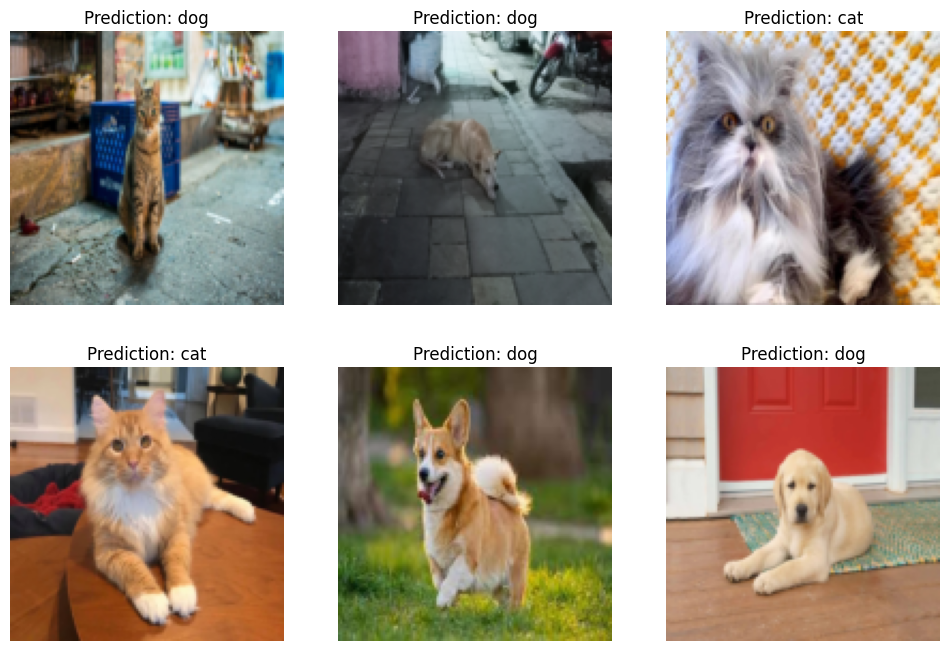

In [41]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

image_folder = '/content/myimages'

image_files = os.listdir(image_folder)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()
grid_rows, grid_cols = 2, 3


for i, image_file in enumerate(image_files):
    if i >= (grid_rows * grid_cols):
        break


    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
        class_label = pred.item()

    ax = plt.subplot(grid_rows, grid_cols, i + 1)
    ax.set_title('Prediction: {}'.format(ad[class_label]))
    ax.axis('off')
    img = image.cpu().squeeze(0).numpy().transpose((1, 2, 0))
    plt.imshow(img)

plt.show()
